# Mock Cycle Dependence on Domain Size
For constant $k$ (repetitive equations), does the mock cycle convergence rate tend quickly to its asymototic value as the domain size grows? It would seem so, since it relates to local components (high frequencies).
* Comparing $kh = 0$ with GS, 2/1 coarsening and $kh = 0.5$ with Kaczmarz, 4/2 coarsening.

In [235]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import helmholtz.repetitive.coarsening_repetitive as hrc
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [259]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Domain size.
n = 96

# Repetitive framework.
repetitive = True
# Number of test vectors.
num_examples = 3
# Number of relaxation sweeps to relax the TVs and to use in coarsening optimization
# (determined by relaxation shrinkage).
num_sweeps = 5

In [260]:
def mock_conv_factor(kh, aggregate_size, num_components):
    # Create fine-level matrix.
    a = hm.linalg.helmholtz_1d_operator(kh, n)
    # Use default Kacmzarz for kh != 0.
    level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

    # Create relaxed vectors.
    x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
    b = np.zeros_like(x)
    x, _ = hm.solve.run.run_iterative_method(level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)

    # Construct coarsening on an aggregate.
    x_aggregate_t = np.concatenate(
        tuple(hm.linalg.get_window(x, offset, aggregate_size)
              for offset in range(max((4 * aggregate_size) // x.shape[1], 1))), axis=1).transpose()

    # Tile the same coarsening over all aggregates.
    r, s = hm.setup.coarsening_uniform.create_coarsening(x_aggregate_t, num_components)
    r = hrc.Coarsener(r)
    print("kh ", kh, "r", r.asarray(), "s", s)

    # coarsener = hm.setup.coarsening_uniform.UniformCoarsener(level, x, num_sweeps, repetitive=True)
    # r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
    #     coarsener.get_optimal_coarsening(1)
    # info = coarsener.get_coarsening_info(1, fmt="dataframe")
    # _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
    #              "eff {:.2f}".format(
    #     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
    # info

    # Calculate mock cycle convergence.
    nu_values = np.arange(1, num_sweeps + 1)
    m_values = np.arange(2, 11, dtype=int)
    conv = pd.DataFrame(np.array([
        mock_conv_factor_for_domain_size(kh, r, aggregate_size, m * aggregate_size, nu_values)
        for m in m_values]),
            index=m_values, columns=nu_values)
    return conv

def mock_conv_factor_for_domain_size(kh, r, aggregate_size, m, nu_values):
    """Returns thre mock cycle conv factor for a domain of size m instead of n."""
    # Create fine-level matrix.
    a = hm.linalg.helmholtz_1d_operator(kh, m)
    # Use default Kacmzarz for kh != 0.
    level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    r_csr = r.tile(m // aggregate_size)
    return np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, r_csr, nu) for nu in nu_values])

In [276]:
cases = [
    (0, 2, 1),      # Laplace
    (0.5, 4, 2),    # kh=0.5, 4/2
    (0.5, 6, 2),    # kh=0.5, 6/2 (Karsten found it to be good)
    (0.5, 6, 3),    # kh=0.5, 6/3
]
case_conv = [mock_conv_factor(*case) for case in cases]

kh  0 r [[-0.745 -0.668]] s [0.112 0.014]
kh  0.5 r [[-0.448 -0.576 -0.56  -0.393]
 [ 0.61   0.271 -0.284 -0.688]] s [0.25  0.151 0.044 0.009]
kh  0.5 r [[ 0.191  0.079 -0.156 -0.438 -0.622 -0.595]
 [ 0.353  0.623  0.594  0.316 -0.005 -0.187]] s [0.204 0.18  0.119 0.052 0.019 0.006]
kh  0.5 r [[-0.457 -0.458 -0.193  0.207  0.498  0.503]
 [-0.059  0.297  0.607  0.642  0.328 -0.14 ]
 [ 0.63   0.368 -0.072 -0.076  0.316  0.598]] s [0.235 0.202 0.087 0.044 0.018 0.007]


kh 0 a 2 nc 1


,1,2,3,4,5
2,0.19,0.08,0.03,0.03,0.03
3,0.21,0.11,0.02,0.02,0.02
4,0.24,0.11,0.06,0.03,0.02
5,0.26,0.11,0.05,0.03,0.03
6,0.27,0.11,0.06,0.03,0.03


kh 0.5 a 4 nc 2


,1,2,3,4,5
2,0.38,0.21,0.11,0.07,0.05
3,0.41,0.25,0.11,0.10,0.08
4,0.44,0.23,0.12,0.14,0.09
5,0.42,0.23,0.12,0.14,0.10
6,0.49,0.24,0.14,0.13,0.11


kh 0.5 a 6 nc 2


,1,2,3,4,5
2,0.83,0.75,0.64,0.54,0.45
3,0.74,0.75,0.55,0.55,0.46
4,0.69,0.73,0.61,0.52,0.46
5,0.80,0.70,0.54,0.50,0.47
6,0.82,0.68,0.65,0.54,0.37


kh 0.5 a 6 nc 3


,1,2,3,4,5
2,0.41,0.24,0.14,0.08,0.06
3,0.43,0.24,0.12,0.11,0.09
4,0.49,0.23,0.13,0.11,0.09
5,0.49,0.24,0.13,0.11,0.09
6,0.54,0.24,0.12,0.11,0.09


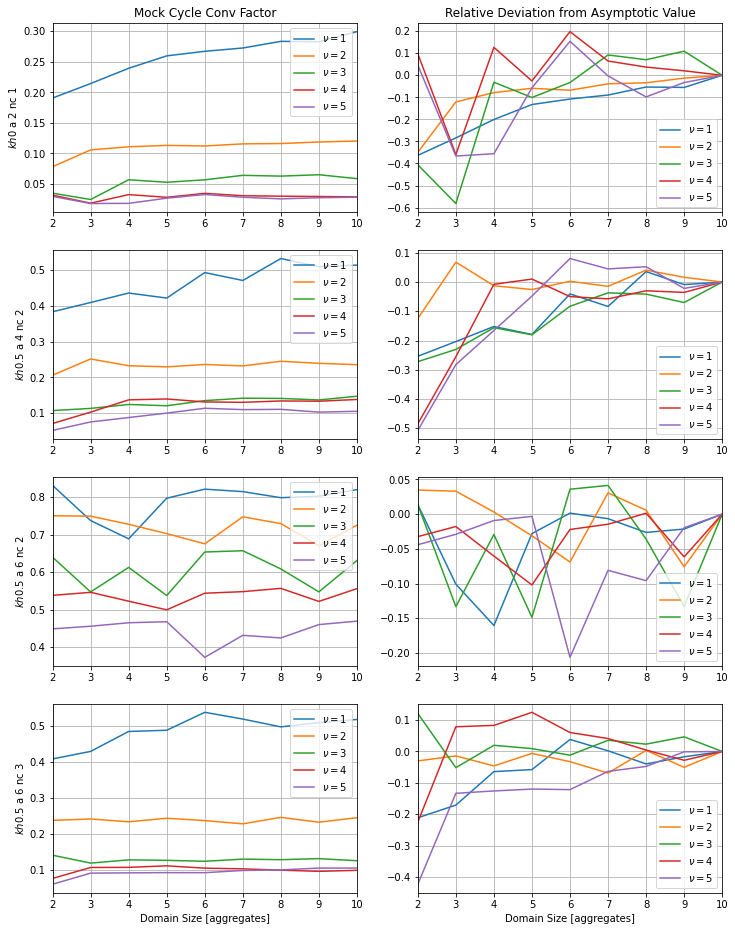

In [280]:
fig, axs = plt.subplots(len(cases), 2, figsize=(12, 4 * len(cases)))

for row, (case, conv) in enumerate(zip(cases, case_conv)):
    kh, a, nc = case
    # Mock cycle convergence vs. domain size [aggregates] and nu=1,...,6.
    print("kh {} a {} nc {}".format(kh, a, nc))
    display(conv[:5])
    
    ax_row = axs[row] if len(cases) > 1 else axs
    error = (conv - conv.iloc[-1]) / conv.iloc[-1]
    nu_values = conv.columns
    m_values = conv.index

    ax = ax_row[0]
    for nu in nu_values:
        ax.plot(m_values, conv[nu], label="$\\nu = {}$".format(nu))
    ax.grid(True);
    ax.set_xlim([2, 10]);
    if row == len(cases) - 1:
        ax.set_xlabel("Domain Size [aggregates]")
    ax.set_ylabel("$kh {}$ a {} nc {}".format(kh, a, nc))
    if row == 0:
        ax.set_title("Mock Cycle Conv Factor");
    ax.legend();

    ax = ax_row[1]
    for nu in nu_values:
        ax.plot(m_values, error[nu], label="$\\nu = {}$".format(nu))
    ax.grid(True);
    ax.set_xlim([2, 10]);
    if row == len(cases) - 1:
        ax.set_xlabel("Domain Size [aggregates]")
    if row == 0:
        ax.set_title("Relative Deviation from Asymptotic Value");
    ax.legend();

* We get a $20\%$ error for a domain with $4$ aggregates already.
* In fact, since the convergence factor itself is noisy, that's probably much smaller.
* The error is much for smaller for $\nu \geq 2$, which we're anyway interested in. For $\nu=1$ the bias due to small domain is more pronounced (since relaxation also converges the intermediate components there, so the high frequencies are not necessarily the bottleneck? The explanation is anyway not that important.)

### Question
* kh = 0.5 with 6/2 does not give good mock cycle rates, although Karsten found the corresponding 2-level to work in practice. 4/2 or 6/3 work. Why is that?